In [103]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from scipy.stats import mannwhitneyu
from pathlib import Path

In [104]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

In [118]:
base_path = Path("/Users/stimpfli/Desktop/nmf2-paper/hybrid_controller_new_step/simulation_results_workstation_final/simulation_results")
all_folders = base_path.glob("*pts*")

# Now in each folder for each pkl file open the observation list
# From the observation list get obs_list[-1]["fly"][0] the last fly position
# Generate a scatter plot for each condition with the last fly z position¨
# Chnage the color if the adhesion is on
# Save the figure in the base directory

save_path = base_path / "panel_adh.pdf"

controllers = ["cpg", "rule_based", "hybrid"]
terrain = ["flat", "blocks", "gapped", "mixed"]
adhesion = [True]

conditions = [(c, t) for t in terrain for c in controllers]
n_conditions = len(conditions)

#sim_time = 1.0
#init_time = 0.0
timestep = 1e-4
all_rows = []
all_colors = np.tile(["r", "b"], n_conditions)

# Stabilization period of 0.3s
start_pts = 3000
all_dir = True

for controller, terrain in conditions:
    for adh in adhesion:
        path = base_path / f"{terrain}/{controller}"
        if not path.is_dir():
            print(f"Path {path} does not exist")
            continue
        all_pkl = list(path.glob("*.pkl"))
        assert len(all_pkl) > 1, f"Path {path} does not contain any pkl file"
        data_pts = []
        for pkl_file in all_pkl:
            with open(pkl_file, "rb") as f:
                try:
                    obs_list = pickle.load(f)
                except:
                    obs_list = []
            #assert len(obs_list) == sim_time * 10_000    
            if len(obs_list) > start_pts:
                if all_dir:
                    distance = np.linalg.norm(obs_list[-1]["fly"][0][:2] - obs_list[start_pts]["fly"][0][:2])
                else:
                    distance = obs_list[-1]["fly"][0][0] - obs_list[start_pts]["fly"][0][0]
                exp_len = (len(obs_list) - start_pts) * timestep
            else:
                distance = 0.0
                exp_len = 100
            speed = distance / exp_len
            all_rows.append([controller.lower(), terrain.lower(), adh, speed, distance])

speed_df = pd.DataFrame(
    all_rows, columns=["controller", "terrain", "adhesion", "speed", "distance"]
)
#speed_df.to_csv("outputs/mean_speed.csv", index=False)

In [119]:
speed_df_norm = speed_df.copy()
for controller in controllers:
    full_speed = np.nanmean(speed_df[(speed_df["controller"] == controller) & (speed_df["terrain"] == "flat")]["speed"])
    print(full_speed)
    speed_df_norm.loc[speed_df_norm["controller"] == controller, "speed"] /= full_speed

14.947460095087688
11.681958317756653
15.050026575724285


In [120]:
#speed_df.iloc[speed_df["speed"].argmax()] = np.nan

In [121]:
print(
    speed_df[speed_df["terrain"] == "flat"]["speed"].min(),
    speed_df[speed_df["terrain"] == "flat"]["speed"].max(),
)
print(
    speed_df_norm[speed_df_norm["terrain"] != "flat"]["speed"].min(),
    speed_df_norm[speed_df_norm["terrain"] != "flat"]["speed"].max(),
)

10.9637983640035 15.32732645670573
0.0 2.062177821678892


/var/folders/g_/c0_j6ct50dz58057rf7b3_s00000gq/T/ipykernel_28145/3858222280.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/Users/stimpfli/anaconda3/envs/data_analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 45.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/stimpfli/anaconda3/envs/data_analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/stimpfli/anaconda3/envs/data_analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  

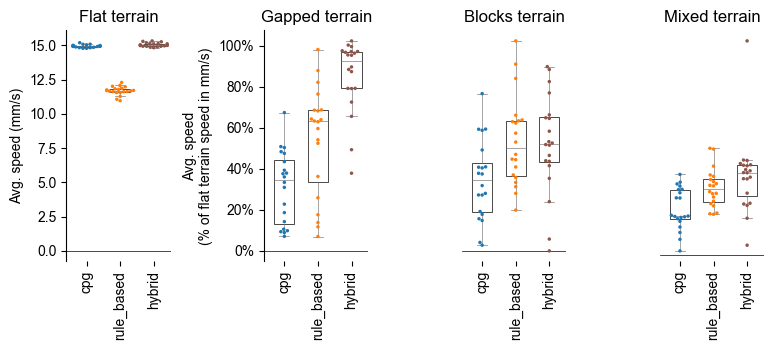

In [122]:

x_pos_lookup = {
    ("cpg", "flat"): 0,
    ("rule_based", "flat"): 1,
    ("hybrid", "flat"): 2,
    ("cpg", "gapped"): 5,
    ("rule_based", "gapped"): 6,
    ("hybrid", "gapped"): 7,
    ("cpg", "blocks"): 10,
    ("rule_based", "blocks"): 11,
    ("hybrid", "blocks"): 12,
    ("cpg", "mixed"): 15,
    ("rule_based", "mixed"): 16,
    ("hybrid", "mixed"): 17,
}
colors_lookup = {
    "cpg": "tab:blue",
    "rule_based": "tab:orange",
    "hybrid": "tab:brown",
}

fig, axs = plt.subplots(1, 4, figsize=(9, 3))
plt.subplots_adjust(wspace=0.9)
for i, terrain_type in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    ax.set_title(f"{terrain_type.title()} terrain")

    df = speed_df if terrain_type == "flat" else speed_df_norm
    ylim = [-0.15 * 10 / 1.15, 25] if terrain_type == "flat" else [-0.15, 1.15]

    boxplot = sns.boxplot(
        x="controller",
        y="speed",
        data=df.query(f"terrain == '{terrain_type}'"),
        width=0.6,
        ax=ax,
        showfliers=False,
        boxprops={"facecolor": "None", "edgecolor": "k", "linewidth": 0.5},
        medianprops={"color": "gray", "linewidth": 0.5},
        whiskerprops={"color": "gray", "linewidth": 0.5},
        capprops={"color": "gray", "linewidth": 0.5},
    )
    sns.swarmplot(
        x="controller",
        y="speed",
        data=df.query(f"terrain == '{terrain_type}'"),
        hue="controller",
        size=2.5,
        palette=["tab:blue", "tab:orange", "tab:brown"],
        ax=ax,
        legend=False,
    )
    ax.set_xlim(-0.6, 2.5)
    #ax.set_ylim(ylim)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.axhline(0.0, color="k", linewidth=0.5)
    if terrain_type not in ["flat", "gapped"]:
        ax.set_ylabel("")
        ax.set_yticks([])
        pass
    if terrain_type == "flat":
        ax.set_ylabel("Avg. speed (mm/s)")
    elif terrain_type == "gapped":
        ax.set_ylabel("Avg. speed\n(% of flat terrain speed in mm/s)")
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
    ax.set_xlabel("")
    sns.despine(ax=ax, bottom=True, left=terrain_type not in ["flat", "gapped"])

"""for i, terrain in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    N = df.query(f"terrain == '{terrain}'").groupby("controller")["speed"].apply(lambda x: np.sum(pd.notna(x)))
    x_axis_label = [f"{controller} (N={n})" for cont in controllers for controller, n in zip(N.index.values, N.values) if cont == controller]
    ax.set_xticks(range(3), x_axis_label, rotation=90)"""

#plt.savefig("outputs/speed_comparison.pdf", transparent=True)
plt.savefig("outputs/relspeed_comparison_2ddist_0stabilization.pdf", transparent=True, bbox_inches='tight')

/var/folders/g_/c0_j6ct50dz58057rf7b3_s00000gq/T/ipykernel_28145/2579464300.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/g_/c0_j6ct50dz58057rf7b3_s00000gq/T/ipykernel_28145/2579464300.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/g_/c0_j6ct50dz58057rf7b3_s00000gq/T/ipykernel_28145/2579464300.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/g_/c0_j6ct50dz58057rf7b3_s00000gq/T/ipykernel_28145/2579464300.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

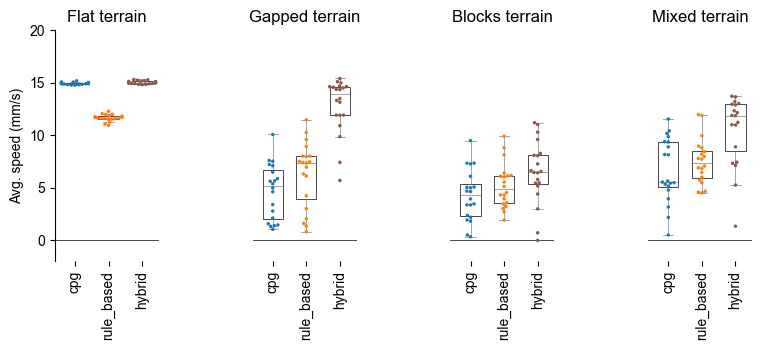

In [123]:

x_pos_lookup = {
    ("cpg", "flat"): 0,
    ("rule_based", "flat"): 1,
    ("hybrid", "flat"): 2,
    ("cpg", "gapped"): 3,
    ("rule_based", "gapped"): 4,
    ("hybrid", "gapped"): 5,
    ("cpg", "blocks"): 6,
    ("rule_based", "blocks"): 7,
    ("hybrid", "blocks"): 8,
    ("cpg", "mixed"): 9,
    ("rule_based", "mixed"): 10,
    ("hybrid", "mixed"): 11,
}
colors_lookup = {
    "cpg": "tab:blue",
    "rule_based": "tab:orange",
    "hybrid": "tab:brown",
}

fig, axs = plt.subplots(1, 4, figsize=(9, 3))
plt.subplots_adjust(wspace=0.9)
for i, terrain_type in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    ax.set_title(f"{terrain_type.title()} terrain")

    df = speed_df
    ylim = [-2.0, 20.0]

    boxplot = sns.boxplot(
        x="controller",
        y="speed",
        data=df.query(f"terrain == '{terrain_type}'"),
        width=0.6,
        ax=ax,
        showfliers=False,
        boxprops={"facecolor": "None", "edgecolor": "k", "linewidth": 0.5},
        medianprops={"color": "gray", "linewidth": 0.5},
        whiskerprops={"color": "gray", "linewidth": 0.5},
        capprops={"color": "gray", "linewidth": 0.5},
    )
    sns.swarmplot(
        x="controller",
        y="speed",
        data=df.query(f"terrain == '{terrain_type}'"),
        hue="controller",
        size=2.5,
        palette=["tab:blue", "tab:orange", "tab:brown"],
        ax=ax,
        legend=False,
        warn_thresh=1.0
    )
    ax.set_xlim(-0.6, 2.5)
    ax.set_ylim(ylim)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.axhline(0.0, color="k", linewidth=0.5)
    if terrain_type not in ["flat"]:
        ax.set_ylabel("")
        ax.set_yticks([])
        pass
    if terrain_type == "flat":
        ax.set_ylabel("Avg. speed (mm/s)")
    ax.set_xlabel("")
    sns.despine(ax=ax, bottom=True, left=terrain_type not in ["flat"])

"""for i, terrain in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    N = df.query(f"terrain == '{terrain}'").groupby("controller")["speed"].apply(lambda x: np.sum(pd.notna(x)))
    x_axis_label = [f"{controller} (N={n})" for cont in controllers for controller, n in zip(N.index.values, N.values) if cont == controller]
    ax.set_xticks(range(3), x_axis_label, rotation=90)"""

#plt.savefig("outputs/speed_comparison.pdf", transparent=True)20
plt.savefig("outputs/speed_comparison_2ddist_0stabilization.pdf", transparent=True, bbox_inches='tight')

In [124]:
for variable, df in [("Absolute speed", speed_df), ("Normalized speed", speed_df_norm)]:
    for terrain_type in ["flat", "gapped", "blocks", "mixed"]:
        hybrid_pts = df[
            (df["controller"] == "hybrid") & (df["terrain"] == terrain_type)
        ]["speed"].values
        for controller in ["cpg", "rule_based"]:
            my_pts = df[
                (df["controller"] == controller) & (df["terrain"] == terrain_type)
            ]["speed"].values
            u, p = mannwhitneyu(
                my_pts, hybrid_pts, alternative="less", method="asymptotic"
            )
            print(f"{variable} - {terrain_type} - {controller} vs hybrid: {p:.6f}")

Absolute speed - flat - cpg vs hybrid: 0.009646
Absolute speed - flat - rule_based vs hybrid: 0.000000
Absolute speed - gapped - cpg vs hybrid: 0.000000
Absolute speed - gapped - rule_based vs hybrid: 0.000001
Absolute speed - blocks - cpg vs hybrid: 0.005291
Absolute speed - blocks - rule_based vs hybrid: 0.026552
Absolute speed - mixed - cpg vs hybrid: 0.000208
Absolute speed - mixed - rule_based vs hybrid: 0.000614
Normalized speed - flat - cpg vs hybrid: 0.611805
Normalized speed - flat - rule_based vs hybrid: 0.691613
Normalized speed - gapped - cpg vs hybrid: 0.000000
Normalized speed - gapped - rule_based vs hybrid: 0.000072
Normalized speed - blocks - cpg vs hybrid: 0.005291
Normalized speed - blocks - rule_based vs hybrid: 0.430215
Normalized speed - mixed - cpg vs hybrid: 0.000230
Normalized speed - mixed - rule_based vs hybrid: 0.045454


In [125]:
# find steady state
base_path = Path("/Users/stimpfli/Desktop/nmf2-paper/hybrid_controller_new_step/simulation_results_workstation_physicserrorcsteps_newincrv2/simulation_results")
all_folders = base_path.glob("*pts*")

# Now in each folder for each pkl file open the observation list
# From the observation list get obs_list[-1]["fly"][0] the last fly position
# Generate a scatter plot for each condition with the last fly z position¨
# Chnage the color if the adhesion is on
# Save the figure in the base directory

save_path = base_path / "panel_adh.pdf"

controllers = ["cpg", "rule_based", "hybrid"]
terrain = ["flat"]
adhesion = [True]

conditions = [(c, t) for t in terrain for c in controllers]
n_conditions = len(conditions)

#sim_time = 1.0
#init_time = 0.0
timestep = 1e-4

start_pts = 0
all_dir = True

controller = "rule_based"
terrain = "flat"

all_obs_list = []
all_conditions = []

for controller, terrain in conditions:
    path = base_path / f"{terrain}/{controller}"
    all_pkl = list(path.glob("*.pkl"))
    
    assert len(all_pkl) > 1, f"Path {path} does not contain any pkl file"
    
    for pkl_file in all_pkl:
        seed = str(pkl_file).split("/")[-1].split("_")[1]
        all_conditions.append((controller, terrain, seed))
        with open(pkl_file, "rb") as f:
            try:
                obs_list = pickle.load(f)
            except:
                obs_list = []
        
        all_obs_list.append(obs_list)

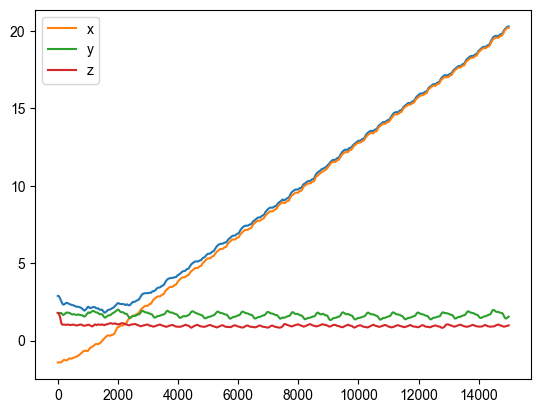

In [126]:
fly_speed = np.array([obs["fly"][0] for obs in all_obs_list[0]])
plt.plot(np.linalg.norm(fly_speed, axis=1))
plt.plot(fly_speed[:, 0], label="x")
plt.plot(fly_speed[:, 1], label="y")
plt.plot(fly_speed[:, 2], label="z")

plt.legend()


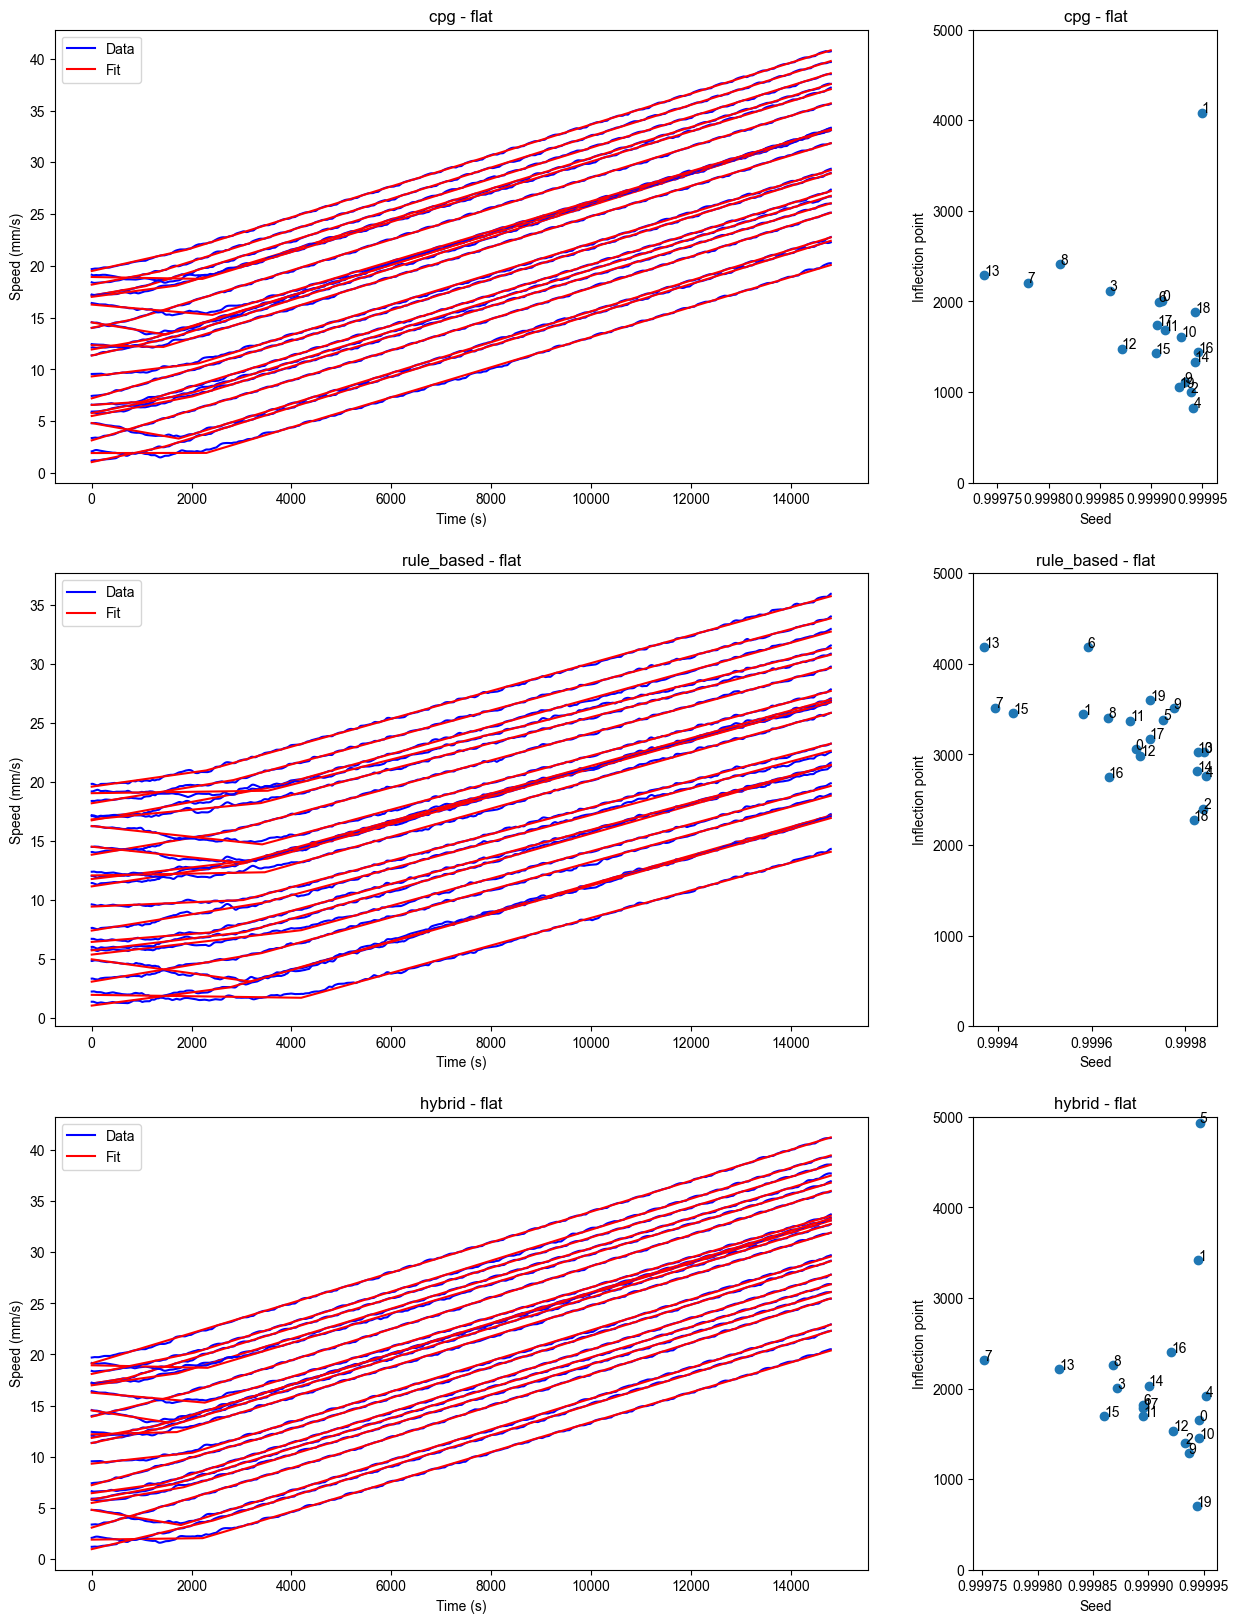

In [127]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def piecewise_linear(x, x0, y0, k1, k2):
    """
    Define the piecewise linear function.
    
    Parameters:
    - x: independent variable
    - x0: point of inflection
    - y0: y-value at x0
    - k1: slope of the first segment
    - k2: slope of the second segment
    
    Returns:
    - y: piecewise linear function value at x
    """
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0 - k1*x0, lambda x:k2*x + y0 - k2*x0])

def fit_piecewise_linear(x_data, y_data):
    """
    Fit a piecewise linear function to the data.
    
    Parameters:
    - x_data: array-like, independent variable
    - y_data: array-like, dependent variable
    
    Returns:
    - popt: optimal values for the parameters
    - pcov: the estimated covariance of popt
    """
    
    # Initial guesses
    x0_guess = np.median(x_data)  # initial guess for the inflection point
    y0_guess = np.median(y_data)  # initial guess for the y-value at the inflection point
    k1_guess = 1.0                # initial guess for the first slope
    k2_guess = -1.0               # initial guess for the second slope
    
    # Fit the piecewise linear function
    popt, pcov = curve_fit(piecewise_linear, x_data, y_data, p0=[x0_guess, y0_guess, k1_guess, k2_guess])
    
    return popt, pcov

# small ratio for the right columns
fig, axs = plt.subplots(3, 2, figsize=(15, 20), gridspec_kw={'width_ratios': [1, 0.3]})
conditions_lookup = {
    ("cpg", "flat"): 0,
    ("rule_based", "flat"): 1,
    ("hybrid", "flat"): 2,}


inflection_points = [[], [], []]
seed_inflection_points = [[], [], []]
r2_values = [[], [], []]
increment = np.zeros(3)

for i, (controller, terrain, seed) in enumerate(all_conditions):
    ax = axs[conditions_lookup[(controller, terrain)], 0]
    ax.set_title(f"{controller} - {terrain}")
    fly_speed = np.array([obs["fly"][0][:2] for obs in all_obs_list[i]])

    # Generate noisy data
    np.random.seed(0)
    y_data = np.linalg.norm(fly_speed, axis=1).astype(float)[200:]
    x_data = np.arange(len(y_data)).astype(float)

    # Fit the piecewise linear function
    popt, pcov = fit_piecewise_linear(x_data, y_data)

    incr = increment[conditions_lookup[(controller, terrain)]]

    ax.plot(x_data, y_data+incr, 'b-')
    ax.plot(x_data, piecewise_linear(x_data, *popt)+incr, 'r-')

    increment[conditions_lookup[(controller, terrain)]] += 1.0

    inflection_points[conditions_lookup[(controller, terrain)]].append(popt[0])
    seed_inflection_points[conditions_lookup[(controller, terrain)]].append(seed)
    r2_values[conditions_lookup[(controller, terrain)]].append(np.corrcoef(y_data, piecewise_linear(x_data, *popt))[0, 1])

for ax in axs[:, 0]:
    ax.legend(["Data", "Fit"])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Speed (mm/s)")

for i, ax in enumerate(axs[:, 1]):
    all_inflection_pts = np.array(inflection_points[i])
    # add seed as text next to the inflection pts
    x = r2_values[i]
    ax.scatter(x, all_inflection_pts)
    for k, txt in enumerate(seed_inflection_points[i]):
        ax.annotate(txt, (x[k], all_inflection_pts[k]))
    ax.set_title(f"{controllers[i]} - {terrain}")
    ax.set_xlabel("Seed")
    ax.set_ylabel("Inflection point")
    ax.set_ylim(0, 5000)

